# Recurrent Neuronal Networks; LSTM

In [1]:
import numpy as np

with np.load('rnn-challenge-data.npz') as f:
    print(list(f.keys()))
    data_x = f["data_x"]
    data_y = f["data_y"]
    val_x = f["val_x"]
    val_y = f["val_y"]
    test_x = f["test_x"]

print([each.shape for each in [data_x, data_y, val_x, val_y, test_x]])

['data_x', 'data_y', 'val_x', 'val_y', 'test_x']
[(400,), (400,), (100,), (100,), (250,)]


In [5]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [7]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 

def one_hot_encode(seq: str, vocab: [str]):
    eye = np.eye(4)
    return np.array([eye[vocab.index(char)] for char in seq])


class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y, vocab):
        self.x = np.array([one_hot_encode(seq, vocab) for seq in data_x], dtype=np.float32)
        #eye = np.eye(5)
        self.y = data_y  # np.array([eye[c] for c in data_y], dtype=np.float32)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.shape[0]


class LSTMCharRNN(nn.Module):
    def __init__(self, vocab, n_classes, n_hidden=256, n_layers=2,
                 drop_prob=0.5, lr=0.001):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        self.vocab = vocab
        self.rnn = nn.LSTM(input_size=len(vocab), hidden_size=n_hidden,
                           num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_classes)
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x, hidden):
        '''x is the input and `hidden` is the hidden/cell state .'''
        hidden_t = [self.dropout(h) for h in hidden]
        x = x.to(device)
        out, hidden_t = self.rnn(x, hidden_t)
        return self.fc(out), hidden_t

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        return torch.zeros(2, self.n_layers, batch_size, self.n_hidden)

def stretch_flat(tensor, times):
    assert len(tensor.shape) == 1
    return tensor.unsqueeze(0).repeat(times,1).T.flatten()

def train(
    lr = 0.001,
    epochs = 1
):
    seq_length = 400
    val_seq_length = 1200
    vocab = ["A", "C", "G", "T"]
    n_classes = 5
    model = LSTMCharRNN(vocab=vocab, n_classes=n_classes, n_layers=1, drop_prob=0.0)

    batch_size = 20
    trainloader = torch.utils.data.DataLoader(Dataset(data_x, data_y, vocab), batch_size=batch_size, shuffle=True)
    val_batch_size = 100
    val_loader = torch.utils.data.DataLoader(Dataset(val_x, val_y, vocab), batch_size=val_batch_size, shuffle=False)

    losses = []
    val_losses = []
    accuracy = []
    train_accuracy = []

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.to(device)

    def train():
        model.train()
        for data, label in trainloader:
            h = model.init_hidden(batch_size)
            h = tuple([each.data for each in h])
            data = data.to(device)
            label = label.to(device)
            model.zero_grad()
            output, h = model(data, h)
            loss = criterion(output.view(-1, n_classes), stretch_flat(label, times=seq_length))
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            losses.append(loss.item())

    def evaluate():
        model.eval()
        with torch.no_grad():
            for data, label in val_loader:
                h = model.init_hidden(val_batch_size)
                h = tuple([each.data for each in h])
                data = data.to(device)
                label = label.to(device)
                output, h = model(data, h)
                loss = criterion(output.view(-1, n_classes), stretch_flat(label, times=val_seq_length))
                val_losses.append(loss.item())

                output = nn.LogSoftmax(dim=0)(output)
                sums = output.sum(axis=1)
                pred = sums.max(axis=1).indices
                accuracy.append(len((pred == label).nonzero()) / len(pred))

    def train_acc():
        model.eval()
        train_acc = 0
        with torch.no_grad():
            for data, label in trainloader:
                h = model.init_hidden(batch_size)
                h = tuple([each.data for each in h])
                data = data.to(device)
                label = label.to(device)
                output, h = model(data, h)
                output = nn.LogSoftmax(dim=0)(output)
                sums = output.sum(axis=1)
                pred = sums.max(axis=1).indices
                train_acc += len((pred == label).nonzero())
            train_accuracy.append(train_acc / len(data_x))

    evaluate()
    train_acc()
    for e in tqdm(range(epochs)):
        train()
        evaluate()
        train_acc()

    return losses, val_losses, accuracy, train_accuracy, model

epochs = 5
losses, val_losses, accuracy, train_accuracy, model = train(epochs=epochs)

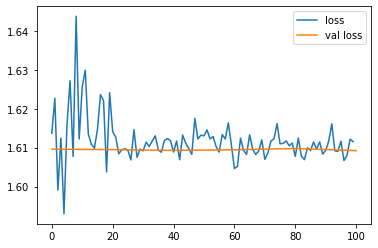

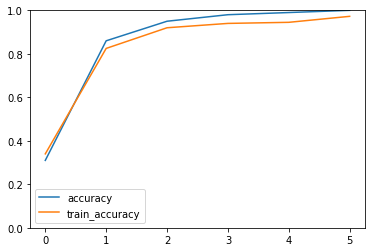

1.0


In [8]:
plt.plot(losses, label="loss")
plt.plot(list(range(0, len(losses)+1, len(losses)//epochs)), val_losses, label="val loss")
#plt.plot(list(range(0, len(losses)+1, len(losses)//epochs)), accuracy, label="accuracy")
plt.legend()
#plt.ylim(bottom=0)
plt.show()
plt.plot(accuracy, label="accuracy")
#plt.ylim(top=1,bottom=0)
#plt.legend()
#plt.show()
plt.plot(train_accuracy, label="train_accuracy")
plt.ylim(top=1,bottom=0)
plt.legend()
plt.show()
print(accuracy[-1])

In [5]:
def predict():
    vocab = ["A", "C", "G", "T"]
    test_batch_size = 250
    test_seq_length = 2000
    test_loader = torch.utils.data.DataLoader(
        Dataset(test_x, np.zeros((250,)), vocab),
        batch_size=test_batch_size,
        shuffle=False
    )
    model.eval()
    test_losses = []
    with torch.no_grad():
        for data, label in test_loader:
            h = model.init_hidden(test_batch_size)
            h = tuple([each.data for each in h])
            data = data.to(device)
            label = label.to(device)
            output, h = model(data, h)
            output = nn.LogSoftmax(dim=0)(output)
            sums = output.sum(axis=1)
            pred = sums.max(axis=1).indices
            pred = pred.numpy()
            assert pred.shape == (250,)
            return pred

prediction = predict()
np.save('prediction.npy', prediction)

In [6]:
prediction.shape

(250,)